In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GlueDataset,
    GlueDataTrainingArguments,
    Trainer,
    TrainingArguments,
    default_data_collator,
    glue_compute_metrics,
    glue_output_modes)
from influence_utils.utils_hans import HansDataset

import torch
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from influence_utils.influence import compute_s_test
from influence_utils import glue_utils

In [2]:
# dir_name = "/export/home/Experiments/20200708/MNLI_data/remove_100_harmful/output_dir/"

In [3]:
from glob import glob
from collections import defaultdict
original_model_dirs = ["/export/home/Experiments/20200706/"]
remove_dirs_0 = glob("/export/home/Experiments/20200708/MNLI_data/remove_*/output_dir/")
remove_dirs_1 = glob("/export/home/Experiments/20200714/MNLI_data/remove_*/output_dir/")
experiment_dirs = original_model_dirs + remove_dirs_0 + remove_dirs_1
combined_num_entried = len(original_model_dirs) + len(remove_dirs_0) + len(remove_dirs_1)
if len(set(experiment_dirs)) != combined_num_entried:
    raise ValueError
len(original_model_dirs), len(remove_dirs_0), len(remove_dirs_1), combined_num_entried, len(experiment_dirs)

(1, 9, 26, 36, 36)

In [4]:
# [_dir.split("/")[-3].split("_") for _dir in experiment_dirs[1:]][13][2:]
# glob("/export/home/Experiments/20200708/MNLI_data/remove_*/output_dir/") + ["/export/home/Experiments/20200706/"]

In [5]:
output_collections = defaultdict(dict)
from tqdm import tqdm
for dir_name in tqdm(experiment_dirs):
    if "remove_20_smallest_distance_10000" in dir_name:
        continue
    tokenizer = AutoTokenizer.from_pretrained(dir_name)
    model = AutoModelForSequenceClassification.from_pretrained(dir_name)
    model.eval()

    train_dataset = GlueDataset(
        args=GlueDataTrainingArguments(
            task_name="mnli",
            max_seq_length=128,
            data_dir="/export/home/Data/Glue/MNLI/"),
        tokenizer=tokenizer)

    eval_dataset = GlueDataset(
        args=GlueDataTrainingArguments(
            task_name="mnli",
            max_seq_length=128,
            data_dir="/export/home/Data/Glue/MNLI/"),
        tokenizer=tokenizer,
        mode="dev")


    def hans_data_collator(features):
        """
        Data collator that removes the "pairID" key if present.
        """
        batch = default_data_collator(features)
        _ = batch.pop("pairID", None)
        return batch


    def get_dataloader(dataset, batch_size, data_collator) -> DataLoader:
        sampler = SequentialSampler(dataset)

        data_loader = DataLoader(
            dataset,
            sampler=sampler,
            batch_size=batch_size,
            collate_fn=data_collator,
        )

        return data_loader


    def decode_one_example(inputs, logits=None):
        if inputs["input_ids"].shape[0] != 1:
            raise ValueError

        X = tokenizer.decode(inputs["input_ids"][0])
        Y = train_dataset.label_list[inputs["labels"].item()]
        if logits is not None:
            Y_hat = train_dataset.label_list[
                logits.argmax(dim=-1).item()]
            return X, Y, Y_hat
        else:
            return X, Y

    output_mode = glue_output_modes["mnli"]
    def build_compute_metrics_fn(task_name: str):
        def compute_metrics_fn(p):
            if output_mode == "classification":
                preds = np.argmax(p.predictions, axis=1)
            elif output_mode == "regression":
                preds = np.squeeze(p.predictions)
            return glue_compute_metrics(task_name, preds, p.label_ids)

        return compute_metrics_fn


    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
        data_collator=hans_data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=build_compute_metrics_fn("mnli"),
    )

    train_batch_data_loader = get_dataloader(
        train_dataset,
        batch_size=160,
        data_collator=hans_data_collator)

    train_instance_data_loader = get_dataloader(
        train_dataset,
        batch_size=1,
        data_collator=hans_data_collator)

    eval_instance_data_loader = get_dataloader(
        eval_dataset,
        batch_size=1,
        data_collator=hans_data_collator)


    def run_forward(model, inputs):
        # Implicitly used trainer and model
        has_labels = any(inputs.get(k) is not None for k in ["labels", "lm_labels", "masked_lm_labels"])

        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(trainer.args.device)
        if trainer.args.past_index >= 0:
            inputs["mems"] = past

        with torch.no_grad():
            outputs = model(**inputs)
            if has_labels:
                step_eval_loss, logits = outputs[:2]
                return step_eval_loss, logits
            else:
                logits = outputs[0]
                return logits


    def visualize(inputs):
        X, Y = decode_one_example(inputs)
        premise, hypothesis = X.split("[CLS]")[1].split("[SEP]")[:2]
        print(f"\tP: {premise.strip()}\n\tH: {hypothesis.strip()}\n\tL: {Y}")
        
        
    for i, test_inputs in enumerate(eval_instance_data_loader):
        step_eval_loss, logits = run_forward(model, test_inputs)
        if i == 41:
            break

    print(f"Dirname: {dir_name}")
    print(logits, logits.softmax(dim=-1), step_eval_loss)
    if "20200706" in dir_name:
        for remove_type in ["random", "harmful", "helpful"]:
            output_collections[remove_type][0] = (logits.softmax(dim=-1), step_eval_loss)
    else:
#         if "remove_100_random" in dir_name:
#             remove_type = "random"
#             num_remove = 100
#         if "remove_20_random" in dir_name:
#             remove_type = "random"
#             num_remove = 20
#         if "remove_1_random" in dir_name:
#             remove_type = "random"
#             num_remove = 1
#         if "remove_100_harmful" in dir_name:
#             remove_type = "harmful"
#             num_remove = 100
#         if "remove_20_harmful" in dir_name:
#             remove_type = "harmful"
#             num_remove = 20
#         if "remove_1_harmful" in dir_name:
#             remove_type = "harmful"
#             num_remove = 1
#         if "remove_100_helpful" in dir_name:
#             remove_type = "helpful"
#             num_remove = 100
#         if "remove_20_helpful" in dir_name:
#             remove_type = "helpful"
#             num_remove = 20
#         if "remove_1_helpful" in dir_name:
#             remove_type = "helpful"
#             num_remove = 1
        num_remove = int(dir_name.split("/")[-3].split("_")[1])
        remove_type = "_".join(dir_name.split("/")[-3].split("_")[2:])

        output_collections[remove_type][num_remove] = (logits.softmax(dim=-1), step_eval_loss)

  0%|          | 0/36 [00:00<?, ?it/s]You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


  3%|▎         | 1/36 [00:19<11:12, 19.23s/it]

Dirname: /export/home/Experiments/20200706/
tensor([[-1.0180,  1.2213, -0.6772]], device='cuda:0') tensor([[0.0848, 0.7960, 0.1192]], device='cuda:0') tensor(2.4675, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


  6%|▌         | 2/36 [00:37<10:48, 19.07s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_random/output_dir/
tensor([[-1.0040,  1.2066, -0.6275]], device='cuda:0') tensor([[0.0864, 0.7878, 0.1259]], device='cuda:0') tensor(2.4491, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


  8%|▊         | 3/36 [00:58<10:42, 19.46s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_helpful/output_dir/
tensor([[-1.7610,  1.6030, -0.5113]], device='cuda:0') tensor([[0.0299, 0.8656, 0.1045]], device='cuda:0') tensor(3.5084, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 11%|█         | 4/36 [01:14<09:52, 18.53s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_harmful/output_dir/
tensor([[-0.7497,  0.6718, -0.3156]], device='cuda:0') tensor([[0.1496, 0.6196, 0.2308]], device='cuda:0') tensor(1.9001, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 14%|█▍        | 5/36 [01:36<10:01, 19.42s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_helpful/output_dir/
tensor([[-1.3308,  1.3717, -0.5758]], device='cuda:0') tensor([[0.0554, 0.8267, 0.1179]], device='cuda:0') tensor(2.8928, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 17%|█▋        | 6/36 [01:52<09:18, 18.62s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_harmful/output_dir/
tensor([[-1.1228,  1.1602, -0.6199]], device='cuda:0') tensor([[0.0803, 0.7870, 0.1327]], device='cuda:0') tensor(2.5225, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 19%|█▉        | 7/36 [02:11<09:03, 18.74s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_helpful/output_dir/
tensor([[-1.0725,  1.2105, -0.6713]], device='cuda:0') tensor([[0.0813, 0.7973, 0.1214]], device='cuda:0') tensor(2.5096, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 22%|██▏       | 8/36 [02:31<08:48, 18.86s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_random/output_dir/
tensor([[-1.0991,  1.1363, -0.6035]], device='cuda:0') tensor([[0.0834, 0.7797, 0.1369]], device='cuda:0') tensor(2.4842, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 25%|██▌       | 9/36 [02:50<08:33, 19.02s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_random/output_dir/
tensor([[-1.0223,  1.3247, -0.8949]], device='cuda:0') tensor([[0.0794, 0.8304, 0.0902]], device='cuda:0') tensor(2.5329, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 28%|██▊       | 10/36 [03:13<08:44, 20.18s/it]

Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_harmful/output_dir/
tensor([[-0.9332,  1.1125, -0.6165]], device='cuda:0') tensor([[0.0989, 0.7653, 0.1358]], device='cuda:0') tensor(2.3132, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 31%|███       | 11/36 [03:31<08:07, 19.52s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_random_entailment/output_dir/
tensor([[-1.0446,  1.2729, -0.7883]], device='cuda:0') tensor([[0.0804, 0.8158, 0.1039]], device='cuda:0') tensor(2.5211, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 33%|███▎      | 12/36 [03:55<08:18, 20.77s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_smallest_distance_1000/output_dir/
tensor([[-1.0246,  1.2948, -0.7910]], device='cuda:0') tensor([[0.0804, 0.8180, 0.1016]], device='cuda:0') tensor(2.5204, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 36%|███▌      | 13/36 [04:13<07:45, 20.22s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_smallest_distance_1000/output_dir/
tensor([[-1.0620,  1.0125, -0.5427]], device='cuda:0') tensor([[0.0940, 0.7481, 0.1580]], device='cuda:0') tensor(2.3647, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 39%|███▉      | 14/36 [04:34<07:30, 20.47s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_random_neutral/output_dir/
tensor([[-1.0358,  1.2133, -0.6597]], device='cuda:0') tensor([[0.0838, 0.7942, 0.1220]], device='cuda:0') tensor(2.4795, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 42%|████▏     | 15/36 [05:00<07:40, 21.95s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_random_entailment/output_dir/
tensor([[-1.1312,  1.3142, -0.7403]], device='cuda:0') tensor([[0.0714, 0.8231, 0.1055]], device='cuda:0') tensor(2.6400, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 44%|████▍     | 16/36 [05:20<07:10, 21.51s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_smallest_distance_10000/output_dir/
tensor([[-1.0246,  1.2948, -0.7910]], device='cuda:0') tensor([[0.0804, 0.8180, 0.1016]], device='cuda:0') tensor(2.5204, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 47%|████▋     | 17/36 [05:43<06:56, 21.90s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_harmful_10000/output_dir/
tensor([[-1.0170,  1.1703, -0.6928]], device='cuda:0') tensor([[0.0885, 0.7890, 0.1224]], device='cuda:0') tensor(2.4242, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 50%|█████     | 18/36 [06:06<06:40, 22.24s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_harmful_10000/output_dir/
tensor([[-1.1116,  1.0090, -0.4487]], device='cuda:0') tensor([[0.0887, 0.7392, 0.1721]], device='cuda:0') tensor(2.4227, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Network error resolved after 0:00:12.864250, resuming normal operation.
 53%|█████▎    | 19/36 [06:40<07:16, 25.70s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_random_contradiction/output_dir/
tensor([[-1.1204,  1.2116, -0.6356]], device='cuda:0') tensor([[0.0774, 0.7970, 0.1257]], device='cuda:0') tensor(2.5590, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 56%|█████▌    | 20/36 [07:01<06:28, 24.28s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_harmful_1000/output_dir/
tensor([[-1.0424,  1.2252, -0.7366]], device='cuda:0') tensor([[0.0832, 0.8038, 0.1130]], device='cuda:0') tensor(2.4861, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 58%|█████▊    | 21/36 [07:25<06:02, 24.15s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_random_contradiction/output_dir/
tensor([[-1.1336,  1.0878, -0.5171]], device='cuda:0') tensor([[0.0828, 0.7637, 0.1534]], device='cuda:0') tensor(2.4909, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 61%|██████    | 22/36 [07:50<05:40, 24.34s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_random_entailment/output_dir/
tensor([[-1.0454,  1.2567, -0.7632]], device='cuda:0') tensor([[0.0812, 0.8112, 0.1076]], device='cuda:0') tensor(2.5114, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 64%|██████▍   | 23/36 [08:15<05:18, 24.52s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_helpful_10000/output_dir/
tensor([[-1.0725,  1.2105, -0.6713]], device='cuda:0') tensor([[0.0813, 0.7973, 0.1214]], device='cuda:0') tensor(2.5096, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Network error resolved after 0:00:12.672292, resuming normal operation.
 67%|██████▋   | 24/36 [08:52<05:42, 28.55s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_harmful_10000/output_dir/
tensor([[-1.0831,  1.1468, -0.6595]], device='cuda:0') tensor([[0.0846, 0.7863, 0.1292]], device='cuda:0') tensor(2.4703, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Network error resolved after 0:00:11.849573, resuming normal operation.
 69%|██████▉   | 25/36 [09:33<05:54, 32.23s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_helpful_10000/output_dir/
tensor([[-1.2189,  1.3246, -0.7075]], device='cuda:0') tensor([[0.0650, 0.8267, 0.1084]], device='cuda:0') tensor(2.7338, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 72%|███████▏  | 26/36 [10:00<05:06, 30.67s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_helpful_10000/output_dir/
tensor([[-1.4534,  1.3547, -0.4118]], device='cuda:0') tensor([[0.0490, 0.8122, 0.1388]], device='cuda:0') tensor(3.0161, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 75%|███████▌  | 27/36 [10:26<04:23, 29.26s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_helpful_1000/output_dir/
tensor([[-1.1883,  1.3044, -0.7080]], device='cuda:0') tensor([[0.0680, 0.8221, 0.1099]], device='cuda:0') tensor(2.6885, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 78%|███████▊  | 28/36 [10:56<03:55, 29.46s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_random_contradiction/output_dir/
tensor([[-1.0515,  1.1219, -0.5546]], device='cuda:0') tensor([[0.0875, 0.7687, 0.1438]], device='cuda:0') tensor(2.4364, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 81%|████████  | 29/36 [11:23<03:21, 28.79s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_helpful_1000/output_dir/
tensor([[-1.0971,  1.3149, -0.6437]], device='cuda:0') tensor([[0.0728, 0.8126, 0.1146]], device='cuda:0') tensor(2.6196, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 83%|████████▎ | 30/36 [11:56<02:59, 29.86s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_harmful_1000/output_dir/
tensor([[-0.9238,  1.1548, -0.7410]], device='cuda:0') tensor([[0.0981, 0.7841, 0.1178]], device='cuda:0') tensor(2.3218, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 86%|████████▌ | 31/36 [12:29<02:34, 30.94s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_smallest_distance_10000/output_dir/
tensor([[-1.0437,  1.2489, -0.7625]], device='cuda:0') tensor([[0.0818, 0.8099, 0.1084]], device='cuda:0') tensor(2.5035, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 89%|████████▉ | 32/36 [12:59<02:02, 30.61s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_20_random_neutral/output_dir/
tensor([[-1.1650,  1.1213, -0.4839]], device='cuda:0') tensor([[0.0780, 0.7678, 0.1542]], device='cuda:0') tensor(2.5506, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 92%|█████████▏| 33/36 [13:32<01:33, 31.16s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_harmful_1000/output_dir/
tensor([[-1.0619,  1.2035, -0.6073]], device='cuda:0') tensor([[0.0819, 0.7891, 0.1290]], device='cuda:0') tensor(2.5023, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 94%|█████████▍| 34/36 [14:09<01:06, 33.13s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_smallest_distance_1000/output_dir/
tensor([[-1.0437,  1.2489, -0.7625]], device='cuda:0') tensor([[0.0818, 0.8099, 0.1084]], device='cuda:0') tensor(2.5035, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


 97%|█████████▋| 35/36 [14:51<00:35, 35.80s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_1_helpful_1000/output_dir/
tensor([[-1.0599,  1.2237, -0.7199]], device='cuda:0') tensor([[0.0819, 0.8031, 0.1150]], device='cuda:0') tensor(2.5028, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Network error resolved after 0:00:01.578424, resuming normal operation.
100%|██████████| 36/36 [15:35<00:00, 25.99s/it]

Dirname: /export/home/Experiments/20200714/MNLI_data/remove_100_random_neutral/output_dir/
tensor([[-0.9750,  1.1329, -0.7024]], device='cuda:0') tensor([[0.0948, 0.7806, 0.1246]], device='cuda:0') tensor(2.3555, device='cuda:0')


In [6]:
import matplotlib.pyplot as plt

In [8]:
# plt.rcParams["figure.figsize"] = (10, 10)

# for j in range(3):
#     plt.subplot(2, 2, j + 1)
#     plt.title(f"Probs of {train_dataset.label_list[j]}")
#     remove_types = []
#     for remove_type in output_collections.keys():
#         output_tuple = output_collections[remove_type]
#         output_tuple_sorted = sorted([p for p in output_tuple.items()], key=lambda pair: int(pair[0]))
#         # Y = [output_tuple[0][0].squeeze(dim=0)[j], output_tuple[1][0].squeeze(dim=0)[j], output_tuple[20][0].squeeze(dim=0)[j], output_tuple[100][0].squeeze(dim=0)[j]]
#         # X = [0, 1, 20, 100]
#         Y = [p[1][0].squeeze(dim=0)[j].item() for p in output_tuple_sorted]
#         X = [int(p[0]) for p in output_tuple_sorted]
        
#         plt.plot(X, Y, linestyle='--', marker='o')
#         remove_types.append(remove_type)
#     plt.legend(remove_types)
#     plt.xlabel("Number of data-points removed")
    

# plt.subplot(2, 2, 4)
# plt.title("Loss")
# remove_types = []
# for remove_type in output_collections.keys():
#     output_tuple = output_collections[remove_type]
#     output_tuple_sorted = sorted([p for p in output_tuple.items()], key=lambda pair: int(pair[0]))
#     # Y = [output_tuple[0][1], output_tuple[1][1], output_tuple[20][1], output_tuple[100][1]]
#     # X = [0, 1, 20, 100]
#     Y = [p[1][1].item() for p in output_tuple_sorted]
#     X = [int(p[0]) for p in output_tuple_sorted]

#     plt.plot(X, Y, linestyle='--', marker='o')
#     remove_types.append(remove_type)
# plt.legend(remove_types)
# plt.xlabel("Number of data-points removed")

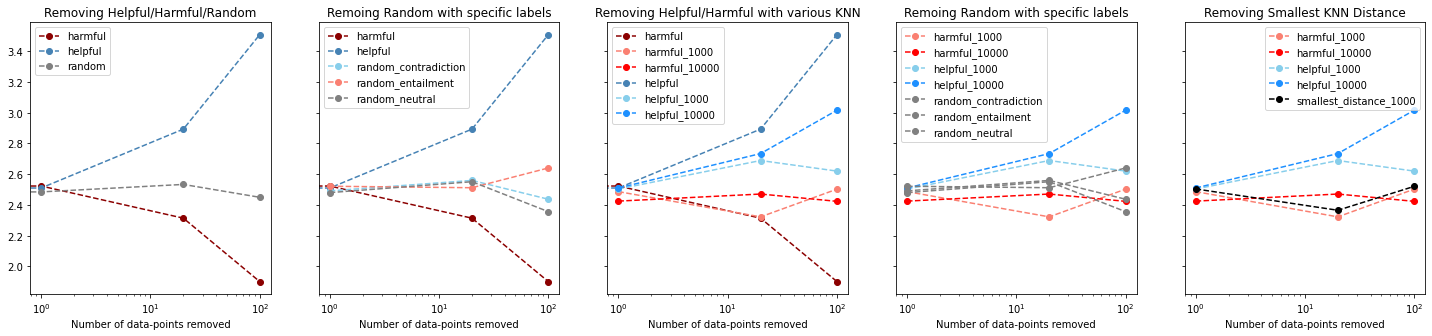

In [10]:
plt.rcParams["figure.figsize"] = (25, 5)
def make_plot(color_dict, axis):
    remove_types = []
    for remove_type in sorted(output_collections.keys()):
        if remove_type not in color_dict.keys():
            continue

        color = color_dict[remove_type]
        output_tuple = output_collections[remove_type]
        output_tuple_sorted = sorted(
            [p for p in output_tuple.items()],
            key=lambda pair: int(pair[0]))
        Y = [p[1][1].item() for p in output_tuple_sorted]
        X = [int(p[0]) for p in output_tuple_sorted]

        axis.plot(X, Y, linestyle='--', marker='o', c=color)
        remove_types.append(remove_type)

    axis.legend(remove_types)
    axis.set_xscale("log")
    axis.set_xlabel("Number of data-points removed")

    
figure, axes = plt.subplots(1, 5, sharex=True, sharey=True)

axes[0].set_title("Removing Helpful/Harmful/Random")
make_plot({
            "random": "grey",
            "harmful": "darkred",
            "helpful": "steelblue",
        }, axes[0])


axes[1].set_title("Remoing Random with specific labels")
make_plot({
            "random_neutral": "grey",
            "random_entailment": "salmon",
            "random_contradiction": "skyblue",
            "harmful": "darkred",
            "helpful": "steelblue",
        }, axes[1])


axes[2].set_title("Removing Helpful/Harmful with various KNN")
make_plot({
            "harmful": "darkred",
            "helpful": "steelblue",
            "harmful_10000": "red",
            "helpful_10000": "dodgerblue",
            "harmful_1000": "salmon",
            "helpful_1000": "skyblue"
        }, axes[2])


axes[3].set_title("Remoing Random with specific labels")
make_plot({
            "random_neutral": "grey",
            "random_entailment": "grey",
            "random_contradiction": "grey",
            "harmful_10000": "red",
            "helpful_10000": "dodgerblue",
            "harmful_1000": "salmon",
            "helpful_1000": "skyblue"
        }, axes[3])


axes[4].set_title("Removing Smallest KNN Distance")
make_plot({
            "smallest_distance_1000": "black",
            # "smallest_distance_10000": "black",
            "harmful_10000": "red",
            "helpful_10000": "dodgerblue",
            "harmful_1000": "salmon",
            "helpful_1000": "skyblue"
        }, axes[4])

In [11]:
figure.savefig("./20200715-fig1.pdf")

requests_with_retry encountered retryable exception: 502 Server Error: Bad Gateway for url: https://api.wandb.ai/files/hanguo/huggingface/c1ok8frs/file_stream. args: ('https://api.wandb.ai/files/hanguo/huggingface/c1ok8frs/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}
requests_with_retry encountered retryable exception: 502 Server Error: Bad Gateway for url: https://api.wandb.ai/files/hanguo/huggingface/6vp06y88/file_stream. args: ('https://api.wandb.ai/files/hanguo/huggingface/6vp06y88/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 34, 'content': ["ERROR 2020-07-15T17:47:10.394656 requests_with_retry encountered retryable exception: 502 Server Error: Bad Gateway for url: https://api.wandb.ai/files/hanguo/huggingface/c1ok8frs/file_stream. args: ('https://api.wandb.ai/files/hanguo/huggingface/c1ok8frs/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n"]}}}}
requests_with_retry encountered retryable exception: 502 Serve